# Planet: Understanding the Amazon from Space Challenge

This notebook will show you how to do some basic manipuatlion of the images and label fiels.

Following along from https://github.com/planetlabs/planet-amazon-deforestation/blob/master/planet_chip_examples.ipynb

In [2]:
import sys
import os
import subprocess

# Make sure you have all these packages installed
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display
%matplotlib inline

## Setup

Set `PLANET_KAGGLE_ROOT` to the directory where you've downloaded the TIFF and JPEG zip files, and accompanying CSVs.

In [9]:
PLANET_KAGGLE_ROOT = os.path.abspath("./data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

## Inspect Image Labels

The labels are in a CSV entitled labels.csv. Note that each image can be tagged with multiple tags. We'll convert them to a one-hot style where each label is a column:

In [10]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [18]:
# Add onehot features for ever label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#  Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


Now, let's look at the labels' frequencies, and which ones co-occure. You'll note that the classes are very unveven: weather related tags are much more frequent than the land use tags, eg: elective_logging)

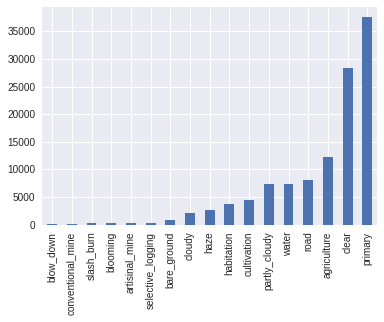

In [13]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


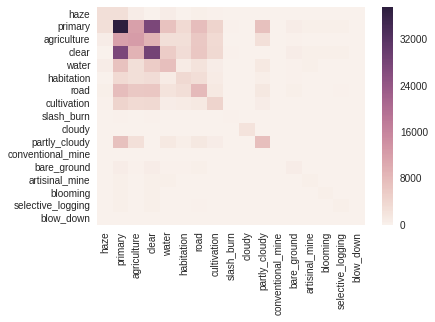

In [14]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

# Copmute the co-occurence matrix
make_cooccurence_matrix(label_list)

Each image should have exactly one weather label:

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


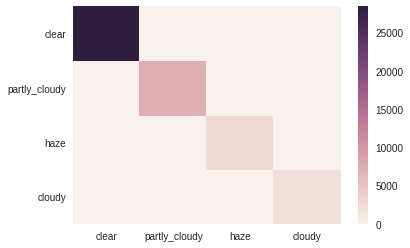

In [16]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


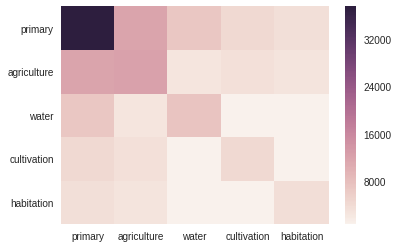

In [17]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


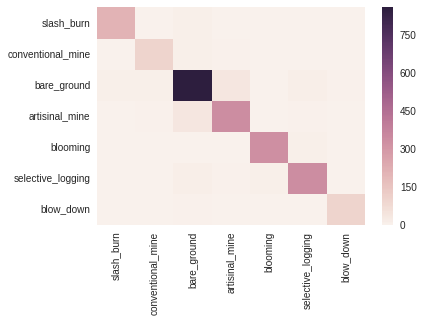

In [19]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

## Inspect Images

Let's display an image and visualize the pixel values. Here we will pick an image, load every single band, then create the RGB stack. These raw images are 16-bit (from 0 to 65535), and contain red, green, blue, and [Near Infrared (NIR)](https://en.wikipedia.org/wiki/Infrared#Regions_within_the_infrared) channels. In this example, we're discarding the NIR band just to simplify the steps to visualize the image. However, you should probably keep it for ML classification.

The files can be easily read into Numpy arrays with the [rasterio](https://mapbox.github.io/rasterio/) library. The code below assumes you've extracted the zip files into directories at PLANET_KAGGLE_ROOT.

In [ ]:
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, basestring):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

def load_image(filename):
    """Return a 4D (r,g,b,nir) Numpy array with the data in the specified TIFF filename."""
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            with rasterio.open(path) as src:
                b, g, r, nir = src.read()
                return np.dstack([r, g, b, nir])

Let's look at an individual image. First, we'll plot a histogram of pixel values in each channel. Note how the intensities are distributed in a relatively narrow region of the dynamic range:

In [ ]:
image_path = sample_images(['primary', 'water', 'road'], n=1)['id'].iloc[0]
image_path = "20170208_164354_0c65_6_13.tif"
rgbn_image = load_image(image_path)
rgb_image = rgbn_image[:,:,;3]
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]
for slice_, name, color in ((r, 'r', 'red'), 
                            (g, 'g', 'green'), (b, 'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100,
             range=[0,rgb_image.max()],
             label_name, color=color, histtype='step')
plt.legend()

We can look at each channel individually:

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nit, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

But when we try to look at the RGB image, something funny's going on:

In [ ]:
plt.imshow(rgb_image)

### Calibrate colors for visual inspection
This is not a problem for analytic purposes, but we can try some transformations to make the image look better for visual inspection.

One way of doing this is to normalize the image channels to a reference color curve. We'll show here how to estimate a reference color curve from other normalized images. We could choose a third party aerial image of a canopy, but here we'll employ the JPEG images procided in the data set, which have already been color-corrected.

In essence, the idea is to transform the pixel values of the test image so that their average and variance match the reference image data.

Get a list of reference images to extract data from:

In [ ]:
# Pull a list of 20,000 image names:
jpg_list = subprocess.check_output('ls ' + PLANET_KAGGLE_JPEG_DIR + ' | head -20000',
                                   shell=True).split('\n')[:-1]
# Select a random sample of 100 among those
np.random.shuffle(jpg_list)
jpg_list = jpg_list[:100]

Read each image (8-bit RGBA) and dump the pixel values to ref_colors, which contains buckets for R, G and B

In [ ]:
ref_colors = [[],[],[]]
for _file in jpg_list:
    # keep only the frist 3 bands, RGB
    _img = mpimg.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, _file))[:,:,:3]
    # Flatten 2D to 1D
    _data = _img.reshape((-1,3))
    # Dump pixel values to aggregation buckets
    for i in range(3):
        ref_colors[i] = ref_colors[i] + _data[:,i].tolist()
        
ref_colors = np.array(ref_colors)

Visualize the histogram of the reference data

In [ ]:
for i, color in enumerate(['r', 'g','b']):
    plt.hist(ref_colors[i], bins=30, range=[0,255], label=color, color=color, histtype='step')
plt.legend()
plt.title('Reference color histograms')

Compute the mean and variance for each channel in the reference data

In [ ]:
ref_means = [np.mean(ref_colors[i]) for i in range(3)]
ref_stds = [np.std(ref_colors[i]) for i in range(3)]

And now we have a function that can calibrate any raw image reasonably well:

In [ ]:
def calibrate_image(rgb_image):
    # Transform test image to 32-bit floats to avoid 
    # surprises when doing arithmetic with it
    calibrated_img = rbg_image.copy().astype('float32')
    
    # Loop over RGB
    for i in range(3):
        # Subtract mean
        calibrated_img[:,:,i] = calibrated_img[:,:,i] - np.mean(calibrated_img[:,:,i])
        # Normalize variance
        calibrated_img[:,:,i] = calibrated_img[:,:,i] / np.std(calibrated_img[:,:,i])
        # Scale to reference
        calibrated_img[:,:,i] = calibrated_img[:,:,i] * ref_std[i] + ref_means[i]
        # Clip any values going out of the valid range
        calibrated_img[:,:,i] = np.clip(calibrated_img[:,:,i], 0, 255)
    
    # Convert to 8-bit insigned int
    return calibrated_img.astype('uint8')

Visualize the color histogram of the newly calibrated test image, and note that it's more evenly distributed throughout the dynamic range, and is closer to the reference data.

In [ ]:
test_image_calibrated = calibrate_image(rgb_image)
for i, color in enumerate(['r', 'g', 'b']):
    plt.hist(test_image_calibrated[:,:,i].ravel(), bins=30, range=[0,255],
             label=color, color=color, histtype='step')
plt.legend()
plt.title('Calibrated image color histograms')

And now we've got something we can recognize:

In [ ]:
plt.imshow(test_image_calibrated)

Putting it all together, to show several images with your tags of choice:

In [ ]:
sampled_images = sample_images(['clear', 'road', 'water'], n=100)
for img_name in samples_images['id']:
    try:
        rgb_img = load_image(img_name)[:,:,:3]
        plt.figure()
        plt.imshow(calibrate_image(rgb_img))
    except:
        continue

## Image Modification

You might want to rotate, flip, or otherwise modify the images for training purposes. Note that the dimensions of the image changes:

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)

In [ ]:
rotated = scipy.ndimage.rotate(rbg_image, angle=45)
plt.imshow(rgb_image)
plt.imshow(rotated)
rotated.shape

In [ ]:
plt.imshow(calibrate_image(rgb_image))
plt.figure()
plt.imshow(calibrate_image(np.fliplr(rgb_image)))